## 1. Set Datatset

- Dataset: Cancer
- Sample : 100/class
- Feature : 4
- Randomseed: 42
- Scale : [-π, π]
- Take 64 sample for training: 32(class 0) and 32(class 1)
- Covert y = {0, 1} to y = {-1, 1}

In [3]:
from sklearn import datasets
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load the cancer dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Shuffle the dataset
np.random.seed(42)
shuffled_indices = np.random.permutation(X.shape[0])
X = X[shuffled_indices]
y = y[shuffled_indices]

# PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)

# # Scale Minmaxscaler to [-π, π]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X = scaler.fit_transform(X)


# Select 100 samples from each class (class 0, 1)
samples_per_class = 100
selected_indices = np.hstack([
    np.where(y == class_idx)[0][:samples_per_class] for class_idx in range(2)
])

X_selected = X[selected_indices]
y_selected = y[selected_indices]


# Take 32 samples per class for training
train_samples_per_class = 32
train_indices = np.hstack([
    np.where(y_selected == class_idx)[0][:train_samples_per_class] for class_idx in range(2)
])

X_train = X_selected[train_indices]
y_train = y_selected[train_indices]
y_train = np.where(y_train == 0, -1, 1)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

# Get the indices of the remaining samples (not used for training)
remaining_indices = np.setdiff1d(np.arange(X_selected.shape[0]), train_indices)

X_test = X_selected[remaining_indices]
y_test = y_selected[remaining_indices]
y_test = np.where(y_test == 0, -1, 1)

print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")



Training X shape: (64, 4)
Training y shape: (64,)
Test X shape: (136, 4)
Test y shape: (136,)


In [ ]:
# # Save the training and testing data
# np.savez_compressed("../data/cancer_data.npz", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## 2. Choose Traiable Quantum Feature Map

In [4]:
#!/usr/bin/env python3
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

In [5]:
from src.feature_map import TrainableQuantumFeatureMap

depth = 1

# Train the feature map
tqfm1 = TrainableQuantumFeatureMap(depth=depth, type_ansatz="TwoLocal", optimizer='COBYLA', maxiter=100)
tqfm1.fit(X_train, y_train)

tqfm2 = TrainableQuantumFeatureMap(depth=depth, type_ansatz="RealAmplitudes", optimizer='COBYLA', maxiter=100)
tqfm2.fit(X_train, y_train)

tqfm3 = TrainableQuantumFeatureMap(depth=depth, type_ansatz="EfficientSU2", optimizer='COBYLA', maxiter=100)
tqfm3.fit(X_train, y_train)


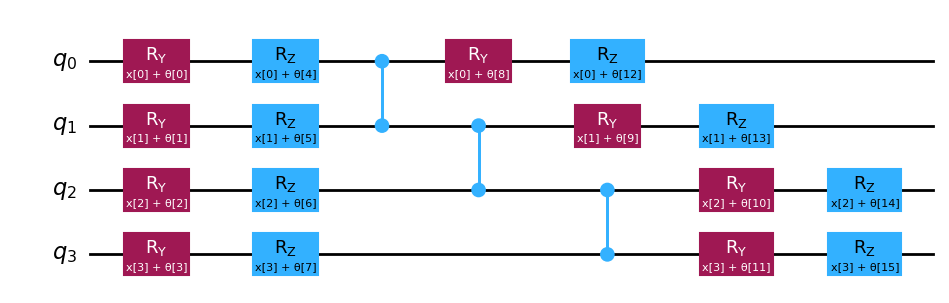

In [6]:
tqfm1.circuit.draw('mpl')

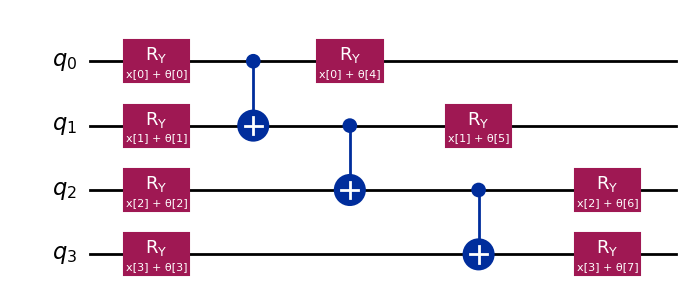

In [7]:
tqfm2.circuit.draw('mpl')

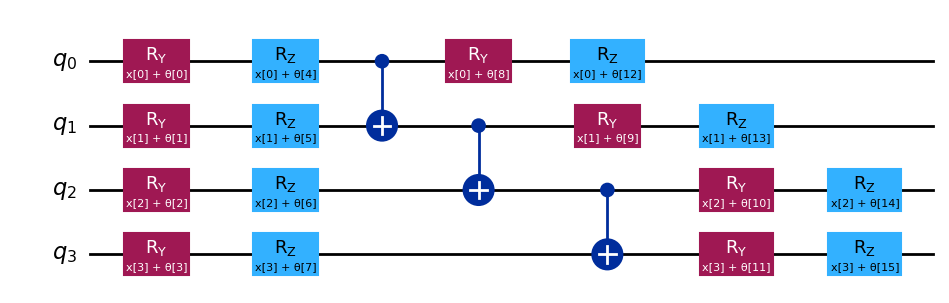

In [8]:
tqfm3.circuit.draw('mpl')


In [9]:
print(f"tqfm1.first_loss: {tqfm1.loss_history[0]}")
print(f"tqfm1.optimal_value: {tqfm1.optimal_value}")

print(f"tqfm2.first_loss: {tqfm2.loss_history[0]}")
print(f"tqfm2.optimal_value: {tqfm2.optimal_value}")

print(f"tqfm3.first_loss: {tqfm3.loss_history[0]}")
print(f"tqfm3.optimal_value: {tqfm3.optimal_value}")

tqfm1.first_loss: 0.5404882426007263
tqfm1.optimal_value: 0.3341283590986681
tqfm2.first_loss: 0.6578331291826964
tqfm2.optimal_value: 0.3258722533962274
tqfm3.first_loss: 0.6152009013524288
tqfm3.optimal_value: 0.21498249836877303


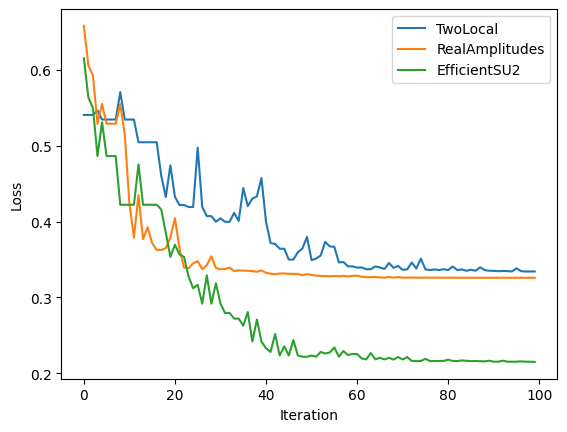

In [10]:
# Draw losses curves in one plot
import matplotlib.pyplot as plt
plt.plot(tqfm1.loss_history, label='TwoLocal')
plt.plot(tqfm2.loss_history, label='RealAmplitudes')
plt.plot(tqfm3.loss_history, label='EfficientSU2')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # Save the trained quantum feature map circuit
# import pickle
# with open(f"../data/tqfm_depth{depth}.pkl", "wb") as f:
# 	pickle.dump(tqfm3, f)

## 3. Kernel Matrix

In [11]:
from src.kernel_estimate import KernelMatrix

kernel_before1 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm1.init_theta, tqfm1.circuit)
kernel_after1 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm1.optimal_params, tqfm1.circuit)

kernel_before2 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm2.init_theta, tqfm2.circuit)
kernel_after2 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm2.optimal_params, tqfm2.circuit)

kernel_before3 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm3.init_theta, tqfm3.circuit)
kernel_after3 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm3.optimal_params, tqfm3.circuit)


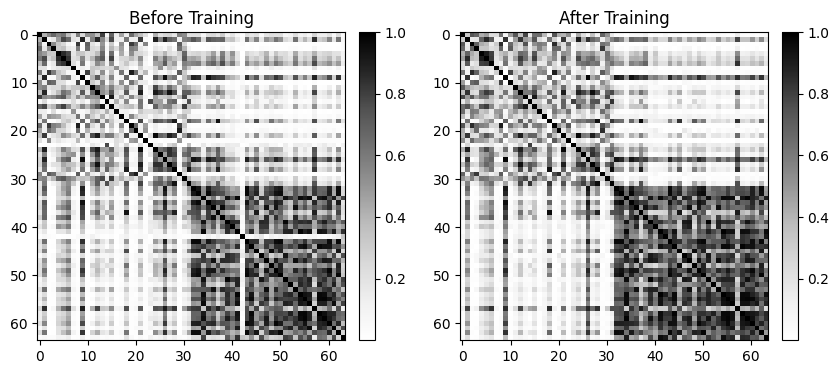

In [12]:
KernelMatrix.plot_multi_kernel_matrices([kernel_before3, kernel_after3],
										titles=['Before Training', 'After Training'],)

## 4. Analyze TQFM

In [13]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before1.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before1[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before1[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after1[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after1[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before1[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after1[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.4074, AFTER=0.3850
  Class +1: BEFORE=0.7955, AFTER=0.5443
Between-class similarity:
  BEFORE=0.4358, AFTER=0.3318

Separability ratio (within/between, higher is better):
BEFORE: 1.3799
AFTER:  1.4004
Change: +1.48%


In [14]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before2.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before2[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before2[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after2[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after2[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before2[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after2[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.4647, AFTER=0.3875
  Class +1: BEFORE=0.6855, AFTER=0.8177
Between-class similarity:
  BEFORE=0.2794, AFTER=0.3095

Separability ratio (within/between, higher is better):
BEFORE: 2.0583
AFTER:  1.9471
Change: -5.40%


In [15]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before3.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before3[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before3[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after3[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after3[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before3[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after3[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.3381, AFTER=0.3860
  Class +1: BEFORE=0.6218, AFTER=0.6914
Between-class similarity:
  BEFORE=0.1985, AFTER=0.1747

Separability ratio (within/between, higher is better):
BEFORE: 2.4174
AFTER:  3.0834
Change: +27.55%


## 5. Classification

In [30]:
# update last change
import importlib
import src.qsvm
importlib.reload(src.qsvm)

<module 'src.qsvm' from 'd:\\QuantumComputing\\SVQSVM\\src\\qsvm.py'>

In [31]:
from src.qsvm import QSVC

qsvc = QSVC(C=1.0, gamma=1.0, type_ansatz='EfficientSU2', optimizer='COBYLA', max_iter=100)
qsvc.fit(X=X_train,
	y=y_train,
	kernel_matrix=kernel_after3,
	theta_optimal=tqfm3.optimal_params,
	parametrized_circuit=tqfm3.circuit)

accuracy = qsvc.score(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Using random initialization with 3 parameters
Test accuracy: 84.56%


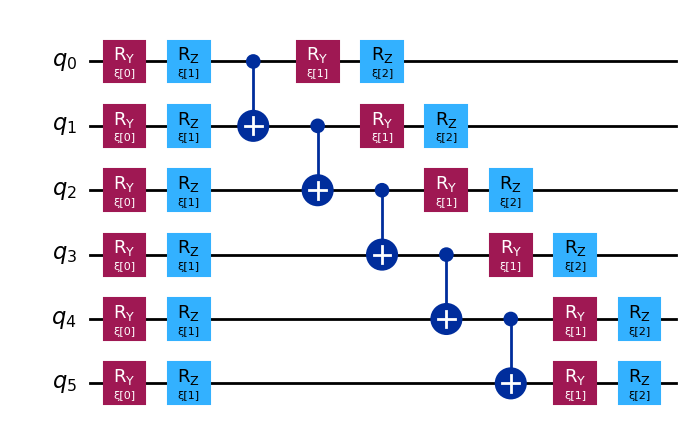

In [32]:
qsvc.ansatz.draw('mpl')

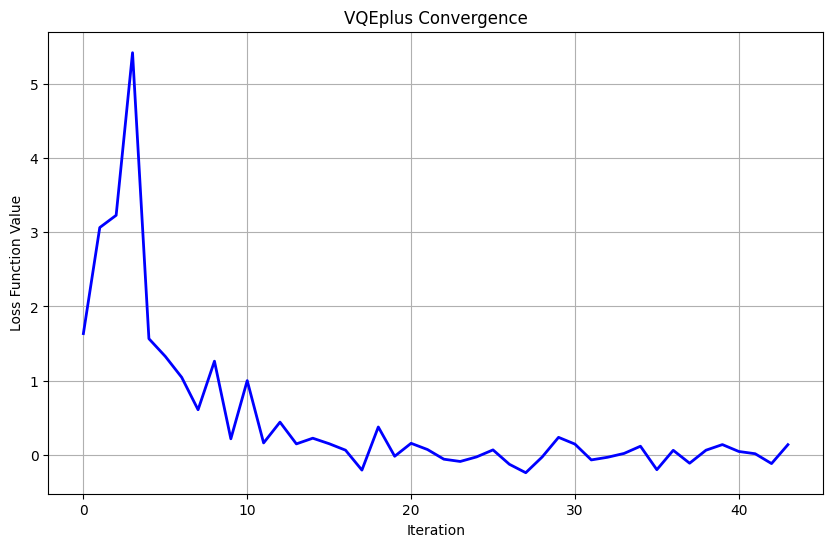

In [36]:
qsvc.plot_convergence()

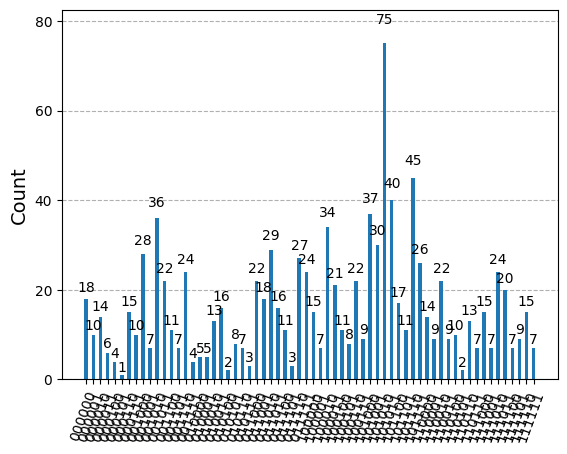

In [33]:
qsvc.plot_state_alpha()

In [35]:
print(len(qsvc.alpha))

64


## 5. Compare classical SVM

In [37]:
kernel_test = KernelMatrix.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm3.optimal_params, tqfm3.circuit)

In [38]:
# Run with tune parameters C and gamma

from sklearn.svm import SVC

for C in [0.1, 1.0, 10.0]:
	for gamma in [0.1, 1.0, 10.0]:
		svm = SVC(C=C, gamma=gamma, kernel='precomputed')
		svm.fit(kernel_after3, y_train)
		y_pred_svm = svm.predict(kernel_test)
		accuracy_svm = np.mean(y_pred_svm == y_test)
		print(f"SVM Test Accuracy with C={C}, gamma={gamma}: {accuracy_svm*100:.2f}%")	



SVM Test Accuracy with C=0.1, gamma=0.1: 92.65%
SVM Test Accuracy with C=0.1, gamma=1.0: 92.65%
SVM Test Accuracy with C=0.1, gamma=10.0: 92.65%
SVM Test Accuracy with C=1.0, gamma=0.1: 94.12%
SVM Test Accuracy with C=1.0, gamma=1.0: 94.12%
SVM Test Accuracy with C=1.0, gamma=10.0: 94.12%
SVM Test Accuracy with C=10.0, gamma=0.1: 96.32%
SVM Test Accuracy with C=10.0, gamma=1.0: 96.32%
SVM Test Accuracy with C=10.0, gamma=10.0: 96.32%
